## MaxwellFDFD Data download
1. download data from link
2. make directory
3. unzip dataset

In [ ]:
!curl -L -o maxwellfdfd.zip https://drive.google.com/uc?id=14-Bl89OzRtLM1MCW2H81Xvivq8EvTrmB

In [ ]:
!mkdir maxwellfdfd
!unzip maxwellfdfd.zip -d ./maxwellfdfd

## CNN model for multi-output regression
1. 4 layer
2. Adam


In [1]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from typing import Any, Tuple
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
import torch
import torch.utils.data
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def compress_image(prev_image, n):
    if n < 2:
        return prev_image

    height = prev_image.shape[0] // n
    width = prev_image.shape[1] // n
    new_image = np.zeros((height, width), dtype="uint8")
    for i in range(0, height):
        for j in range(0, width):
            new_image[i, j] = prev_image[n * i, n * j]

    return new_image

class CEMDataset(torch.utils.data.Dataset):
    DATASETS_TRAIN = [
        'binary_501',
        'binary_502',
        'binary_503',
        'binary_504',
        'binary_505',
        'binary_506',
        'binary_507',
        'binary_508',
        'binary_509',
        'binary_510',
        'binary_511',
        'binary_512',
        'binary_1001',
        'binary_1002',
        'binary_1003',
        # 'binary_rl_fix_501',
        # 'binary_rl_fix_502',
        # 'binary_rl_fix_503',
        # 'binary_rl_fix_504',
        # 'binary_rl_fix_505',
        # 'binary_rl_fix_506',
        # 'binary_rl_fix_507',
        # 'binary_rl_fix_508',
        # 'binary_rl_fix_509',
        # 'binary_rl_fix_510',
        # 'binary_rl_fix_511',
        # 'binary_rl_fix_512',
        # 'binary_rl_fix_513',
        # 'binary_rl_fix_514',
        # 'binary_rl_fix_515',
        # 'binary_rl_fix_516',
        # 'binary_rl_fix_517',
        # 'binary_rl_fix_518',
        # 'binary_rl_fix_519',
        # 'binary_rl_fix_520',
        # 'binary_rl_fix_1001',
        # 'binary_rl_fix_1002',
        # 'binary_rl_fix_1003',
        # 'binary_rl_fix_1004',
        # 'binary_rl_fix_1005',
        # 'binary_rl_fix_1006',
        # 'binary_rl_fix_1007',
        # 'binary_rl_fix_1008',
    ]

    DATASETS_VALID = [
        'binary_1004',
        'binary_test_1001',
        'binary_test_1002',
        'binary_rl_fix_1009',
        'binary_rl_fix_1010',
        'binary_rl_fix_1011',
        'binary_rl_fix_1012',
        'binary_rl_fix_1013',
        'binary_rl_fix_test_1001',
    ]

    DATASETS_TEST = [
        'binary_new_test_501',
        'binary_new_test_1501',
        # 'binary_rl_fix_1014',
        # 'binary_rl_fix_1015',
        # 'binary_rl_fix_test_1002',
        # 'binary_rl_fix_test_1003',
        # 'binary_rl_fix_test_1004',
        # 'binary_rl_fix_test_1005',
        'binary_test_1101',
    ]

    def __init__(self,
                 root: str,
                train: str = 'train',
                scale: int = 1,
                 ) -> None:
        self.train = train
        self.root = root
        self.scale = scale
        self.width = 200 // scale
        self.height = 100 // scale

        if self.train == 'train':
            DATAPATH = os.path.join(root, 'train')
            DATASETS = self.DATASETS_TRAIN
        elif self.train == 'valid':
            DATAPATH = os.path.join(root, 'valid')
            DATASETS = self.DATASETS_VALID
        else:
            DATAPATH = os.path.join(root, 'test')
            DATASETS = self.DATASETS_TEST

        self.data: Any = []
        self.targets = []

        print('data loading ... ')

        # load Train dataset
        for data in DATASETS:
            dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
            dataset = dataframe.values

            # split into input (X) and output (Y) variables
            fileNames = dataset[:, 0]

            # 1. first try max
            dataset[:, 1:25] /= 2767.1
            self.targets.extend(dataset[:, 1:25])
            for idx, file in enumerate(fileNames):
                try:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(int(file))))
                    image = np.array(image).astype(np.uint8)
                except (TypeError, FileNotFoundError) as te:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(idx + 1)))
                    try:
                        image = np.array(image).astype(np.uint8)
                    except:
                        continue
                image = compress_image(image, self.scale)
                self.data.append(np.array(image).flatten(order='C'))

        self.data = np.vstack(self.data).reshape(-1, 1, self.height, self.width)
        self.data = self.data.transpose((0, 1, 2, 3))  # convert to HWC CHW
        print(f'Data Loading Finished. len : {len(self.data)}')


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

    def __len__(self) -> int:
        return len(self.data)

In [3]:
data_dir = os.path.join(os.getcwd(), 'maxwellfdfd')
data_dir

'E:\\cdal\\edu\\display-ai-convergence\\maxwellfdfd'

In [4]:
cem_train = CEMDataset(data_dir, train='train', scale=5)
cem_valid = CEMDataset(data_dir, train='test', scale=5)

data loading ... 
Data Loading Finished. len : 9000
data loading ... 
Data Loading Finished. len : 3000


In [5]:
batch_size = 128
train_dl = DataLoader(cem_train, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(cem_valid, batch_size, shuffle=True, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * 1.

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    s = make_grid(images.detach()[:nmax], nrow=8)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8, padding=5, pad_value=0.5).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

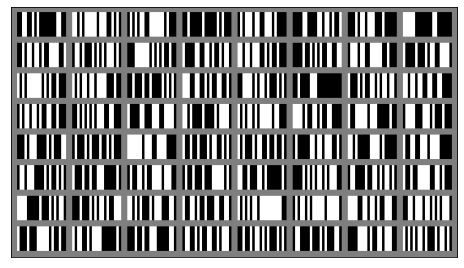

In [7]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
simple_model = nn.Sequential(
    nn.Conv2d(1, 20, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`.

In [13]:
to_device(simple_model, device)
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images.float())
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 1, 20, 40])
out.shape: torch.Size([128, 20, 10, 20])


E:\anaconda3\envs\DAIC\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images.float())                  # Generate predictions
        loss = F.l1_loss(out, labels)               # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images.float())                  # Generate predictions
        loss = F.l1_loss(out, labels)               # Calculate loss
        r2 = rsquare(out, labels)                   # Calculate r2
        return {'val_loss': loss.detach(), 'val_acc': r2}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def rsquare(outputs, labels):
    pred = outputs.cpu().data.numpy()
    pred = pred.reshape(-1, pred.shape[1])
    real = labels.cpu().numpy()
    result = r2_score(pred,  real)
    return torch.tensor(result)

In [15]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            # in: 1 x 20 x 40
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1600, 24),
            nn.Sigmoid()
    )

    def forward(self, xb):
        return self.network(xb)

In [16]:
model = CnnModel()
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=1600, out_features=24, bias=True)
    (13): Sigmoid()
  )
)

Let's verify that the model produces the expected output on a batch of training data. The 24 outputs for each image can be interpreted as transmittance for the 24 target classes (after applying sigmoid).

In [17]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images.float())
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 20, 40])
out.shape: torch.Size([128, 24])
out[0]: tensor([0.5018, 0.4903, 0.5015, 0.4925, 0.5020, 0.5020, 0.4961, 0.4940, 0.4966,
        0.4904, 0.5033, 0.5032, 0.5011, 0.5078, 0.5001, 0.5005, 0.4932, 0.4944,
        0.4985, 0.5027, 0.5050, 0.5082, 0.5031, 0.5070], device='cuda:0',
       grad_fn=<SelectBackward>)


In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=1600, out_features=24, bias=True)
    (13): Sigmoid()
  )
)

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [20]:
model = to_device(CnnModel(), device)

In [21]:
evaluate(model, val_dl)

{'val_loss': 0.17481499910354614, 'val_acc': -39928.705011060105}

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time.

In [22]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.001

In [23]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.1157, val_loss: 0.0920, val_acc: -0.1587
Epoch [1], train_loss: 0.0875, val_loss: 0.0777, val_acc: 0.2431
Epoch [2], train_loss: 0.0835, val_loss: 0.0607, val_acc: 0.5621
Epoch [3], train_loss: 0.0817, val_loss: 0.0555, val_acc: 0.5670
Epoch [4], train_loss: 0.0809, val_loss: 0.0548, val_acc: 0.6208
Epoch [5], train_loss: 0.0802, val_loss: 0.0520, val_acc: 0.6916
Epoch [6], train_loss: 0.0797, val_loss: 0.0564, val_acc: 0.6307
Epoch [7], train_loss: 0.0789, val_loss: 0.0602, val_acc: 0.6145
Epoch [8], train_loss: 0.0785, val_loss: 0.0552, val_acc: 0.5901
Epoch [9], train_loss: 0.0782, val_loss: 0.0616, val_acc: 0.5956
Epoch [10], train_loss: 0.0782, val_loss: 0.0674, val_acc: 0.5820
Epoch [11], train_loss: 0.0778, val_loss: 0.0554, val_acc: 0.6539
Epoch [12], train_loss: 0.0778, val_loss: 0.0547, val_acc: 0.6616
Epoch [13], train_loss: 0.0776, val_loss: 0.0548, val_acc: 0.6425
Epoch [14], train_loss: 0.0772, val_loss: 0.0590, val_acc: 0.6478
Epoch [15], train_l

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

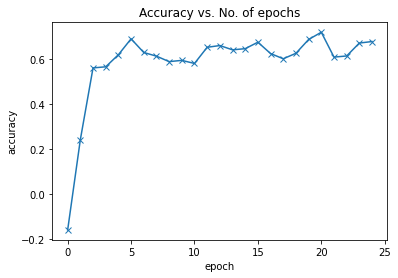

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

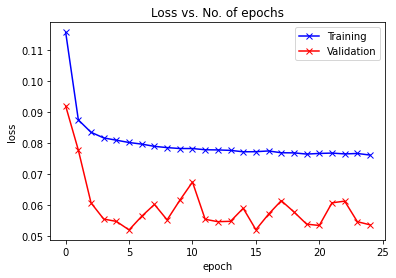

In [27]:
plot_losses(history)